# Regridding the Roemmich/Gilson ARGO clim onto the ASTE grid

In [1]:
import xarray as xr
import xmitgcm
import MITgcm_recipes
import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Get the datasets

### ARGO climatology

In [2]:
data_dir = '/local/data/artemis/workspace/rdussin/Observations/RG_ARGO_clim/originals/'
ds = xr.open_mfdataset(data_dir + '*.nc', decode_times=False, chunks={'TIME':1})

In [3]:
ds

<xarray.Dataset>
Dimensions:                   (LATITUDE: 145, LONGITUDE: 360, PRESSURE: 58, TIME: 156)
Coordinates:
  * LONGITUDE                 (LONGITUDE) float32 20.5 21.5 22.5 23.5 24.5 ...
  * LATITUDE                  (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ...
  * PRESSURE                  (PRESSURE) float32 2.5 10.0 20.0 30.0 40.0 ...
  * TIME                      (TIME) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 ...
Data variables:
    ARGO_SALINITY_MEAN        (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<shape=(58, 145, 360), chunksize=(58, 145, 360)>
    ARGO_SALINITY_ANOMALY     (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<shape=(156, 58, 145, 360), chunksize=(1, 58, 145, 360)>
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<shape=(58, 145, 360), chunksize=(58, 145, 360)>
    MAPPING_MASK              (PRESSURE, LATITUDE, LONGITUDE) float32 dask.array<shape=(58, 145, 360), chunksize=(58, 145, 360)>
    ARGO_TEMPERATURE_ME

### ASTE raw grid

In [4]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

### ASTE output grid

In [5]:
datadir_aste = '/local/data/artemis/workspace/rdussin/ASTE/RUNS/ASTE-Phy-Release1/outputs/'
md = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)
aste_out = xmitgcm.open_mdsdataset(datadir_aste, iters=[], prefix=['T','S','Eta','U','V'],
                                   geometry='llc', nx=270, extra_metadata=md)

## Vertical interpolation

In [6]:
# mean
mdsz = MITgcm_recipes.vertical_interpolation(ds, aste_out['Z'], ['ARGO_SALINITY_MEAN',
                                                                 'ARGO_TEMPERATURE_MEAN'],
                                            lonvar='LONGITUDE', 
                                            latvar='LATITUDE',
                                            depth_varin='PRESSURE',
                                            timevar=None)

In [7]:
# anomalies
adsz = MITgcm_recipes.vertical_interpolation(ds, aste_out['Z'], ['ARGO_SALINITY_ANOMALY',
                                                                 'ARGO_TEMPERATURE_ANOMALY'],
                                             lonvar='LONGITUDE', 
                                             latvar='LATITUDE',
                                             depth_varin='PRESSURE',
                                             timevar='TIME')

In [8]:
def geo_roll_20_to_180(ds, londim):
    datalon=ds[londim].values
    datalon[datalon>180] -= 360
    ind = (np.abs(datalon-180.)).argmin()
    ds[londim] = datalon
    ds = ds.roll(**{londim: -ind-1})
    return ds

In [9]:
mdsz180 = geo_roll_20_to_180(mdsz, 'LONGITUDE')

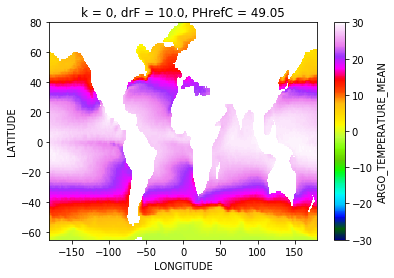

In [10]:
mdsz180['ARGO_TEMPERATURE_MEAN'].sel(k=0).plot(cmap='gist_ncar')

## Regridding

In [11]:
adsz180 = geo_roll_20_to_180(adsz, 'LONGITUDE')

In [12]:
mdsz_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(mdsz180, aste_raw, ['ARGO_SALINITY_MEAN',
                                                                           'ARGO_TEMPERATURE_MEAN'], 
                                                          method='bilinear',
                                                          lonname='LONGITUDE', 
                                                          latname='LATITUDE', 
                                                          point='T', 
                                                          periodic=True, reuse_weights=False,
                                                          regridname='ClimARGO_aste_face')

Overwrite existing file: ClimARGO_aste_face0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ClimARGO_aste_face1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ClimARGO_aste_face2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ClimARGO_aste_face3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ClimARGO_aste_face4.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: ClimARGO_aste_face5.nc 
 You can set reuse_weights=True to save computing time.


In [13]:
adsz_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(adsz180, aste_raw, ['ARGO_SALINITY_ANOMALY',
                                                                           'ARGO_TEMPERATURE_ANOMALY'], 
                                                          method='bilinear',
                                                          lonname='LONGITUDE', 
                                                          latname='LATITUDE', 
                                                          point='T', 
                                                          periodic=True, reuse_weights=True,
                                                          regridname='ClimARGO_aste_face')

Reuse existing file: ClimARGO_aste_face0.nc
Reuse existing file: ClimARGO_aste_face1.nc
Reuse existing file: ClimARGO_aste_face2.nc
Reuse existing file: ClimARGO_aste_face3.nc
Reuse existing file: ClimARGO_aste_face4.nc
Reuse existing file: ClimARGO_aste_face5.nc


## Checking the results

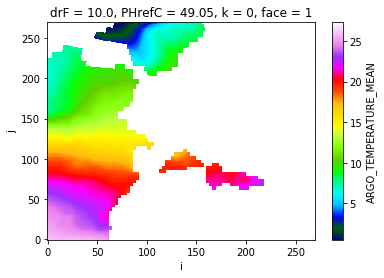

In [14]:
mdsz_aste['ARGO_TEMPERATURE_MEAN'].isel(face=1, k=0).plot(cmap='gist_ncar')

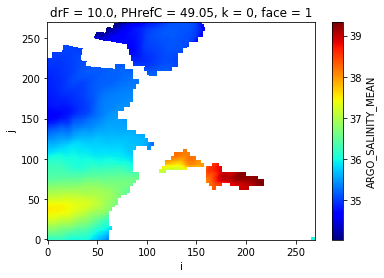

In [15]:
mdsz_aste['ARGO_SALINITY_MEAN'].isel(face=1, k=0).plot(cmap='jet')

## Write to netcdf file

In [16]:
mdsz_aste.to_netcdf(data_dir + '../interp_ASTE/' + 'Roemmich_Clim_ARGO_TS_ASTE.nc')

In [17]:
adsz_aste = adsz_aste.rename({'TIME': 'time'}, inplace=True).transpose(*('time','face','k','j','i'))

In [18]:
adsz_aste.to_netcdf(data_dir + '../interp_ASTE/' + 'Roemmich_AnomClim_ARGO_TS_ASTE.nc', unlimited_dims='time')